# Lab 4 - Kernel Regularized Least Squares

In this lab activity we consider the extension of regularized least squares to non-linear problems using kernel functions.

A brief summary of the tasks:
 1. Generate a simple non-linear data-set
 2. Use **linear** RLS to try and learn with such dataset
 3. Use a **feature transformation** for learning with non-linear data
 4. Implement various kernel functions
 5. Implement kernel RLS
 6. Generate a more complex non-linear data-set
 7. Use kernel RLS for learning on non-linear data, use cross-validation to find the best hyperparameters.

In [497]:
%matplotlib inline
import numpy as np
from numpy.random import Generator
import matplotlib.pyplot as plt
import scipy.spatial


def _check_random_generator(rng: int | Generator | None) -> Generator:
    """Convert rng into a np.random.Generator instance."""
    if rng is None:
        print("⚠️  Warning: Set the `rng` parameter to a NumPy random generator\n"
              "   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure\n"
              "   your results are reproducible. Proceeding with a random seed for now.")
        return np.random.default_rng()
    if isinstance(rng, np.random.Generator):
        return rng
    if isinstance(rng, (int, np.integer)):
        return np.random.default_rng(rng)


In [498]:
def calc_err(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

# Part 1: Learning with a simple non-linear dataset

## Generate quadratic data

In this lab we are going to use regression datasets where the target `Y` is **not a linear function** of the inputs `X`.

As a first example, see the following function to generate quadratic data.

In [499]:
def quadratic_data_gen(n, w, sigma_noise, rng=None):
    rng = _check_random_generator(rng)

    X = rng.uniform(-3, 3, size=(n, 1))
    Xsq = X ** 2
    noise = rng.normal(0, sigma_noise, size=(n, 1))

    # Here we can use scalar multiplication since in dimension 1
    Y = Xsq * w + noise
    
    return X, Y

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.
Shape of x: (100, 1), shape of y: (100, 1)


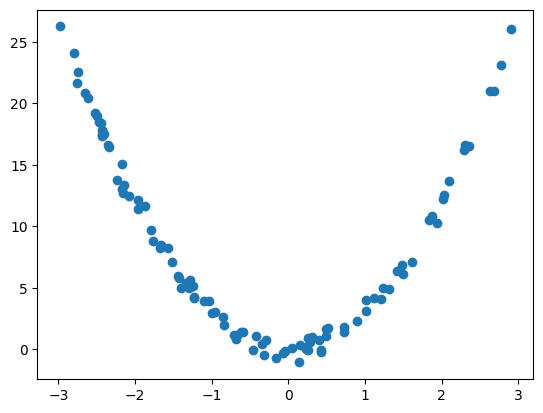

In [500]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

print(f"Shape of x: {x_tr.shape}, shape of y: {y_tr.shape}")
fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr);

## Task 1: Linear RLS

The implementation of linear regularized least-squares is given below in the functions `rls_train` and `rls_predict`. 

Remember: regularized least-squares has the following form

$$(X_{tr}^\top X_{tr} + \lambda n I)w = X_{tr}^\top Y_{tr}$$


Tasks:
 - Use RLS to train a linear regressor for the quadratic data. Comment on the results.

In [501]:
def rls_train(x, y, reg_par):
    cov = x.T @ x + reg_par * x.shape[0] * np.eye(x.shape[1])
    rhs = x.T @ y
    w = np.linalg.solve(cov, rhs)
    return w

def rls_predict(x, w):
    return x @ w

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.


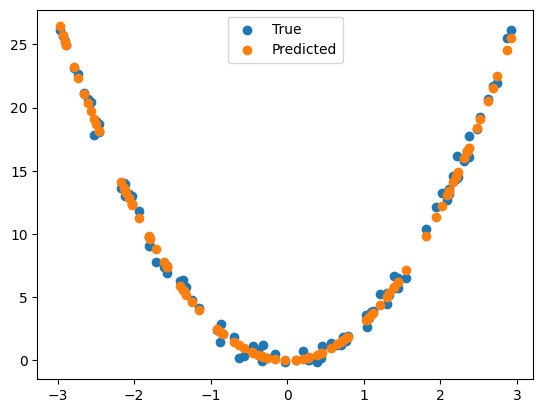

In [502]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

# TODO: put your code here
w = rls_train(x_tr ** 2 , y_tr, reg_par=0.1)
pred_tr = rls_predict(x_tr ** 2, w)

fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr, label="True")
ax.scatter(x_tr, pred_tr, label="Predicted")
ax.legend(loc="upper center");

## Task 2: Feature transform

There is a simple way to use a linear algorithm for learning non-linear data: transforming the input data in such a way to convert the problem into a linear one.

This is a simple fix in some cases, but becomes cumbersome if the datasets are non-linear in a complex way.

Here we adopt this approach to train a RLS classifier with the quadratic dataset:
 1. Generate the quadratic dataset
 2. Transform the data so that it becomes a (n, 2) matrix containing the original input, and a transformed version of itself. Clearly the correct transformation depends on the underlying function (a quadratic function!).
 3. Use the RLS algorithm on the new dataset
 4. Plot **and comment** on the results

In [503]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

# TODO: Instead of just the given xs build a feature matrix with the xs and their squares:
trsf_x_tr = np.concatenate([x_tr, x_tr ** 2], axis=1)
assert trsf_x_tr.shape == (x_tr.shape[0], 2), f"Shape of x_tr is {x_tr.shape}. Expected ({x_tr.shape[0]}, 2)"

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.


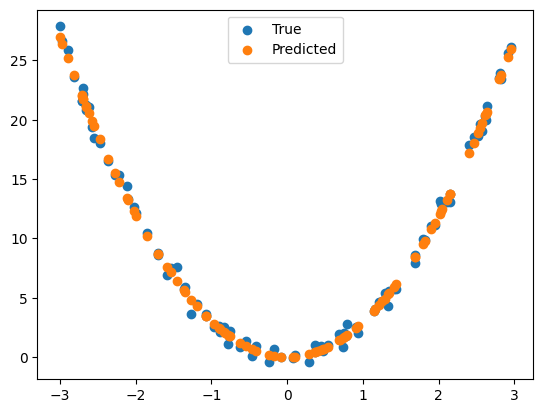

In [504]:
# TODO: Now train a linear regression function on the new data!
trsf_w_rls = rls_train(trsf_x_tr, y_tr, reg_par=0.1)
pred_tr = rls_predict(trsf_x_tr, trsf_w_rls)

fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr, label="True")
ax.scatter(x_tr, pred_tr, label="Predicted")
ax.legend(loc="upper center");

# Part 2: Kernel Least Squares

## Implement 3 types of kernel

The `kernel_matrix` function takes as input two arrays of data, and outputs the kernel matrix evaluated at every pair of points.

You should implement it using the formulas seen in class for the following kernels:
 - linear kernel -- here the `param` argument can be ignored
 - polynomial kernel -- here the `param` argument is the exponent of the kernel
 - gaussian kernel -- here the `param` argument is the kernel length-scale ($\sigma$)

In [505]:
def squared_distances(X1, X2):
    """Compute the matrix of pairwise squared-distances between all points in X1 and in X2.
    """
    return scipy.spatial.distance.cdist(X1, X2, metric='seuclidean')

In [506]:
# TODO: put your code here
def kernel_matrix(X1, X2, kernel_type, param):
    # X1 : array of shape n x d
    # X2 : array of shape m x d
    if kernel_type == 'linear':
        return X1 @ X2.T
    elif kernel_type == 'polynomial':
        exponent = param
        return (X1 @ X2.T + 1) ** exponent
    elif kernel_type == 'gaussian':
        lengthscale = param
        return np.exp(-squared_distances(X1, X2) / (2 * lengthscale ** 2))
    else:
        raise ValueError(kernel_type)

**Task:** Visualize the kernel (e.g. of the Gaussian type) for random data with different length-scales. What can you observe?

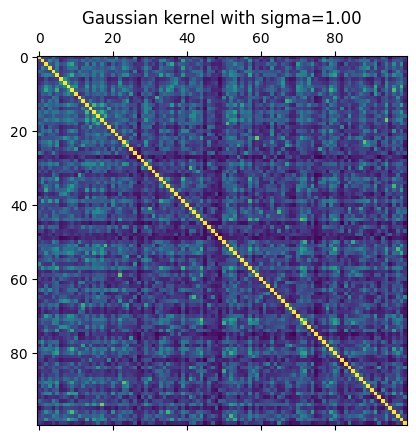

In [507]:
D = np.random.default_rng(42).standard_normal(size=(100, 5))
# TODO: put your code here
lengthscale = 1.0
K = kernel_matrix(D, D, "gaussian", lengthscale)
fig, ax = plt.subplots()
ax.matshow(K)
ax.set_title(f"Gaussian kernel with sigma={lengthscale:.2f}");

## Implement Kernel RLS

Remember that, given kernel $K = k(x_i, x_j)$ for $i=(1, \dots, n)$ and $j=(1, \dots, n)$, KRLS learns a weight-vector with the following formula

$$(K + n \lambda I)w = Y$$

and then predictions on some new point $\tilde{x}$ are given by

$$f^{\mathrm{KRLS}}(\tilde{x}) = k(\tilde{x}, X^{\mathrm{train}}) w$$

In [508]:
# TODO: put your code here
def krls_train(x, y, reg_par, kernel_type, kernel_par):
    w = np.linalg.solve(kernel_matrix(x, x, kernel_type, kernel_par) + reg_par * x.shape[0] * np.eye(x.shape[0]), y)
    return w

def krls_predict(x_ts, x_tr, w, kernel_type, kernel_par):
    return kernel_matrix(x_ts, x_tr, kernel_type, kernel_par) @ w 

Now test the functions you have implemented on the quadratic dataset.

**Tasks:**
 1. use the linear kernel, can you fit the data?
 2. use the polynomial kernel, test the effect of the kernel parameter on the results:
    - describe what happens with a low/high exponent in terms of the bias-variance tradeoff.
 3. use the polynomial kernel, but fix the kernel parameter. Test the effect of the regularization parameter
    - describe what happens with a low/high regularizer in terms of the bias-variance tradeoff

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.


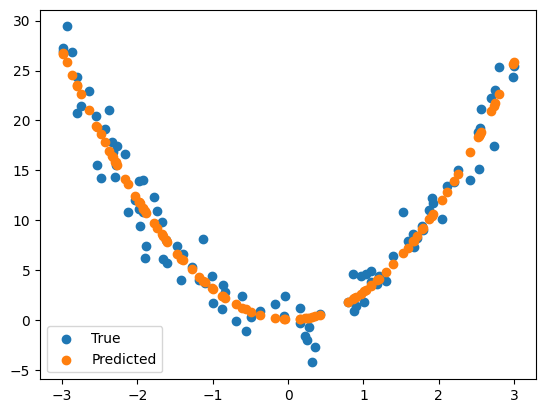

In [509]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 2.0)

# TODO: put your code here
ker_par = 2.0
reg_param = 0.1
ker_type = "polynomial"

w_krls = krls_train(x_tr, y_tr, reg_param, ker_type, ker_par)
ypred_tr = krls_predict(x_tr, x_tr, w_krls, ker_type, ker_par)

fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr, label="True")
ax.scatter(x_tr, ypred_tr, label="Predicted")
ax.legend(loc="best");

**Comments:**
 1. using a linear kernel does not allow to fit the data well, as expected since the data is non-linear.
 2. with a exponent  2 the model is able to fit the data well, while with a high exponent the model overfits the data.
 3. with a low regularization parameter the model fit the data well, while with a high regularization parameter the model underfits the data.

## Generating a more complex non-linear dataset

Define a function to generate a d-dimensional synthetic dataset where the targets `Y` depend non-linearly on the variables `X`.

The parameters of the function are:
 - n : the number of samples
 - d : the dimension of the samples
 - low_d : the lower-bound for the uniformly distributed samples
 - high_d : the higher-bound for the uniformly distributed samples
 - sigma_noise : standard deviation of Gaussian noise added to the targets
 
It should return:
 - X : 2D array of size n, d which fits in the desired bounds
 - Y : 2D array of size n, 1 which is a non-linear function of `X` (and a linear function of `w`)
 
Examples of non-linear regression functions:
 - polynomial dependence of the Y on the X data
 - logarithmic dependence
 - more complex transforms (e.g. trig functions)


In [510]:
def nonlinear_data_gen(n, d, low_d, high_d, sigma_noise, rng=None):
    rng = _check_random_generator(rng)

    X = rng.uniform(low=low_d, high=high_d, size=(n, d))
    assert X.shape == (n, d), "Shape of X incorrect"

    # TODO: put your code here
    Y =  np.log(np.abs(X) + 0.001)* (np.sin(X)**2)
    assert Y.shape == (n, 1), "Shape of Y incorrect"

    # Add noise
    noise = rng.normal(0, sigma_noise, size=(n, 1))
    Y_noisy = Y + noise

    return X, Y_noisy

## KRLS and cross-validation
Now we will use KRLS and k-fold CV to learn on the complex non-linear datasets we have generated.

In this last part you will have to do the following:
 1. Generate a non-linear dataset, find the best hyperparameters (using e.g. the Gaussian kernel) with the training set, and then use them to make predictions on the test-set. Are you able to fit your data well?
 2. Analyse how the amount of noise (see the `sigma_noise` parameter of `nonlinear_data_gen`) influences the best lambda as selected by cross-validation. In particular answer to the following question:
     - How does the best lambda change as you increase/decrease the amount of noise in your dataset? Why? 
     
    **Hint: keep the kernel parameter fixed for this third task, otherwise it might be very hard to see**

In [511]:
def _make_kfold_indices(n_tot, num_folds, rng):
    perm = rng.choice(n_tot, size=n_tot, replace=False)
    return np.array_split(perm, num_folds)


def krls_kfold_valerr(x_tr, y_tr, split_idx, reg_par, kernel_type, kernel_par):
    """
    Compute train/val errors over *given* folds (split_idx is a list of index arrays).
    """
    n_tot = x_tr.shape[0]
    assert len(split_idx) > 1 and all(idx.dtype == int for idx in split_idx)
    assert sum(len(idx) for idx in split_idx) == n_tot

    tr_errs, val_errs = [], []
    for val_ids in split_idx:
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[val_ids] = True

        kf_x_tr, kf_y_tr = x_tr[~val_mask], y_tr[~val_mask]
        kf_x_val, kf_y_val = x_tr[val_mask], y_tr[val_mask]

        w_krls = krls_train(kf_x_tr, kf_y_tr, reg_par=reg_par, kernel_type=kernel_type, kernel_par=kernel_par)
        pred_tr  = krls_predict(kf_x_tr,  kf_x_tr, w_krls, kernel_type=kernel_type, kernel_par=kernel_par)
        pred_val = krls_predict(kf_x_val, kf_x_tr, w_krls, kernel_type=kernel_type, kernel_par=kernel_par)

        tr_errs.append(calc_err(pred_tr,  kf_y_tr))
        val_errs.append(calc_err(pred_val, kf_y_val))

    return np.asarray(tr_errs), np.asarray(val_errs)


def krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, kernel_type, kernel_par_list, rng=None):
    """
    Choose the best parameters for both the regularizer and the kernel parameter according to K-Fold CV.
    """
    n_tot = x_tr.shape[0]
    assert num_folds > 1 and num_folds <= n_tot

    # Precompute shared folds once for fair comparison
    rng = _check_random_generator(rng)
    split_idx = _make_kfold_indices(n_tot, num_folds, rng)

    errors = np.zeros((len(reg_par_list), len(kernel_par_list)))
    for i, reg_par in enumerate(reg_par_list):
        for j, kernel_par in enumerate(kernel_par_list):
            _, val_error = krls_kfold_valerr(x_tr, y_tr, split_idx, reg_par, kernel_type, kernel_par)
            errors[i, j] = np.mean(val_error)

    best_i, best_j = np.unravel_index(np.argmin(errors), errors.shape)
    best_reg_par = reg_par_list[best_i]
    best_kernel_par = kernel_par_list[best_j]
    best_err = errors[best_i, best_j]

    print(f"The best error (MSE={best_err:.5f}) was obtained with "
          f"lambda={best_reg_par}, kernel parameter={best_kernel_par}")

    return best_reg_par, best_kernel_par, best_err

In [512]:
# Data gen parameters
n_tr = 200
n_test = 100
d = 1
low_d = -2
high_d = 2
sigma_noise = 0.1

# TODO: generate datasets
x_tr, y_tr = nonlinear_data_gen(n_tr, d, low_d, high_d, sigma_noise)
x_test, y_test = nonlinear_data_gen(n_test, d, low_d, high_d, sigma_noise)

# K_fold parameters
num_folds = 5
reg_par_list = [0.001, 0.01, 0.1, 1, 10, 50, 100, 500]
ker_type = 'gaussian'
ker_par_list = [0.01 * (10**i) for i in range(5)]

# TODO: Compute HERE the best kernel parameter and the best regularization parameter (use krls_kfoldcv!)
best_reg_par, best_kernel_par, _ = krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, ker_type, ker_par_list)

# TODO: Now retrain on the whole of x_tr with the best parameters and test on x_ts!
w_krls = krls_train(x_tr, y_tr, best_reg_par, ker_type, best_kernel_par)
y_pred = krls_predict(x_test, x_tr, w_krls, ker_type, best_kernel_par)
test_error = calc_err(y_pred, y_test)
print(f'The MSE on the test data is: {test_error:.5f}')

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.
⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.
⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.
The best error (MSE=0.01114) was obtained with lambda=0.001, kernel parameter=1.0
The MSE on the test data is: 0.00997


1 Yes, using KRLS with cross-validation allows to fit the data well.

In [513]:
# TODO: Analyse the effect of noise!
for noise in [0.001, 0.01, 0.1, 0.2, 0.5]:
    print(f'Noise {noise}:')
    x_tr, y_tr = nonlinear_data_gen(n_tr, d, low_d, high_d, noise , rng=42)
    x_test, y_test = nonlinear_data_gen(n_test, d, low_d, high_d, noise ,rng=42)

    # TODO: Use krls_kfoldcv
    best_reg_par, best_kernel_par, _ = krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, ker_type, ker_par_list ,rng=42)

    # TODO: Now retrain on the whole of x_tr with the best parameters and test on x_ts!
    w_krls = krls_train(x_tr, y_tr, best_reg_par, ker_type, best_kernel_par)
    y_pred = krls_predict(x_test, x_tr, w_krls, ker_type, best_kernel_par)
    test_error = calc_err(y_pred, y_test)
    print(f'The MSE on the test data is: {test_error:.5f}\n')

Noise 0.001:
The best error (MSE=0.00013) was obtained with lambda=0.001, kernel parameter=1.0
The MSE on the test data is: 0.00004

Noise 0.01:
The best error (MSE=0.00026) was obtained with lambda=0.001, kernel parameter=1.0
The MSE on the test data is: 0.00013

Noise 0.1:
The best error (MSE=0.01186) was obtained with lambda=0.001, kernel parameter=1.0
The MSE on the test data is: 0.00991

Noise 0.2:
The best error (MSE=0.04600) was obtained with lambda=0.01, kernel parameter=1.0
The MSE on the test data is: 0.04063

Noise 0.5:
The best error (MSE=0.26811) was obtained with lambda=0.01, kernel parameter=1.0
The MSE on the test data is: 0.24268



2 As the amount of noise increases, the mse on the test set also increases, the best lambda has a small increases because it helps to reduce overfitting(high variance) caused by the noise.